In [1]:
import sqlite3
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
def create_db_connection(db_file):
    """
    Create a database connection to the SQLite database
    specified by the db_file
    
    :param db_file: database file
    :return: Connection object or None
    """
    connection = None
    try:
        connection = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return connection

In [3]:
## Get data from Database

db_connection = create_db_connection("genres.db") # can be None!

# Read data as Pandas DataFrame
genres_data = pd.read_sql_query("SELECT * from genrepath", db_connection)
# Remove unnecessary data like 'filename'
genres_data = genres_data.drop('filename', axis=1)

# Encode Labels
genres_list = genres_data.iloc[:,-1]
encoder = LabelEncoder()
y = encoder.fit_transform(genres_list)

# Replace genres from 'genres_data' with encoded labels
genres_data['genre'] = y

# Print first five rows
genres_data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,genre
0,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596748,121.557297,-19.158825,42.351032,...,8.810669,-3.667368,5.751691,-5.162763,0.750948,-1.691938,-0.409953,-2.300209,1.219929,0
1,0.340983,0.095918,1529.835316,2038.617579,3548.820207,0.056044,-207.556793,124.006721,8.930560,35.874687,...,5.376803,-2.239120,4.216963,-6.012273,0.936110,-0.716537,0.293876,-0.287431,0.531573,0
2,0.363603,0.175573,1552.481958,1747.165985,3040.514948,0.076301,-90.754387,140.459900,-29.109968,31.689013,...,5.789265,-8.905224,-1.083720,-9.218359,2.455806,-7.726901,-1.815723,-3.433434,-2.226821,0
3,0.404779,0.141191,1070.119953,1596.333948,2185.028454,0.033309,-199.431152,150.099213,5.647593,26.871927,...,6.087676,-2.476421,-1.073890,-2.874778,0.780977,-3.316932,0.637982,-0.619690,-3.408233,0
4,0.308590,0.091563,1835.494603,1748.362448,3580.945013,0.101500,-160.266037,126.198799,-35.605450,22.153301,...,-2.806384,-6.934123,-7.558618,-9.173553,-4.512165,-5.453538,-0.924161,-4.409333,-11.703781,0


In [4]:
## Step 3: Transform and select features

# Separating features and target variable
train_data_features = genres_data.drop('genre', axis =1)

train_data_target = genres_data["genre"].copy()
train_data_target.columns = ['genre']

# Convert this to a Pandas DataFrame
train_data_target = pd.DataFrame(train_data_target)

print('Shape of features:', train_data_features.shape)
print('Shape of target:', train_data_target.shape)

print(train_data_features.info())
print(train_data_target.info())

# print features and targets
train_data_features.head(10)
train_data_target.head(10)

Shape of features: (1000, 26)
Shape of target: (1000, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   chroma_stft         1000 non-null   float64
 1   rmse                1000 non-null   float64
 2   spectral_centroid   1000 non-null   float64
 3   spectral_bandwidth  1000 non-null   float64
 4   rolloff             1000 non-null   float64
 5   zero_crossing_rate  1000 non-null   float64
 6   mfcc1               1000 non-null   float64
 7   mfcc2               1000 non-null   float64
 8   mfcc3               1000 non-null   float64
 9   mfcc4               1000 non-null   float64
 10  mfcc5               1000 non-null   float64
 11  mfcc6               1000 non-null   float64
 12  mfcc7               1000 non-null   float64
 13  mfcc8               1000 non-null   float64
 14  mfcc9               1000 non-null   float64
 15 

,genre
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [5]:
## Train a simple linear regression model

X_train, X_test, y_train, y_test = train_test_split(train_data_features, train_data_target, test_size=0.2, random_state=0)

lr = LinearRegression()
model = lr.fit(X_train, y_train)

# Make predictions using the trained model on test and training set
features_test_pred = model.predict(X_test)
features_train_pred = model.predict(X_train)

# Evaluate model on train set
RSME_train = metrics.mean_squared_error(y_train, features_train_pred)
RMSE_test = metrics.mean_squared_error(y_test, features_test_pred)


print("RMSE on Train set :", RSME_train)
print("RMSE on Test set :", RMSE_test)

RMSE on Train set : 5.955314914346474
RMSE on Test set : 6.12954143590915


In [6]:
# Predict genre using linear regression
from extract_features import extract

song_tuple = extract('../genres/jazz/jazz.00007.wav')
song = np.asarray(song_tuple).reshape(1, -1).astype(np.float)
song
encoder.inverse_transform([int(model.predict(song))])


array(['classical'], dtype=object)

# K-Means Clustering 

In the next section we try to use K means clustering to cluster the data in the genres

In [50]:
# K-means clustering
import matplotlib.pyplot as plt

#Initialize centroids as random data points
def initializeCentroids(X, labels, K):   
    centroids = np.zeros((K, X.shape[1]))
    for i in range (K):
        selected = labels == i
        selected_idx = np.where(selected)[0]
        random_idx = np.random.choice(selected_idx, size=1, replace=False)
        
        centroids[i, :] = X[random_idx, :]

    return centroids

#Plot the K means while progressing
def plotProgress(X, centroids, previous_centroids, idx, K, i):
    palette = plt.cm.hsv(np.linspace(0,1, num=K))
    
    colors = np.zeros((idx.shape[0], palette.shape[1]))
    for i in range(idx.shape[0]):
        colors[i, :] = palette[int(idx[i][0]), :]
        
    #Plot first two features
    plt.scatter(X[:, 0], X[:, 1], 15, colors)
    
    #Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='black', s=300)
    
    #Plot history of centroids
    #for i in range(centroids.shape[0]):
        #plt.scatter(centroids[i, :], previous_centroids[i, :2], color='black')
        #plt.plot([centroids[i, 0], previous_centroids[i, 0]], [centroids[i, 1], previous_centroids[i, :1]], color='black')
    
#Fint the closest centroid to each data point
def findClosestCentroids(X, centroids):
    K = centroids.shape[0]
    
    idx = np.zeros((X.shape[0], 1))
    
    for i in range(X.shape[0]):
        distance_from_centroids = np.zeros((K, 1))
        
        for j in range(K):
            
            distance_from_centroids[j] = np.linalg.norm(X[i, :] - centroids[j, :])**2
        
        idx[i] = np.argmin(distance_from_centroids)
    
    return idx

def computeCentroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))
    
    for i in range(K):
        activated_by_id = idx == i
        n_activated = np.sum(activated_by_id)
        if n_activated:
            X_activated = np.multiply(activated_by_id, X)
            centroids[i, :] = X_activated.sum(axis=0) / n_activated
        
    return centroids

K-Means iteration 0/20...
Accuracy on dataset: 0.213
K-Means iteration 1/20...
Accuracy on dataset: 0.219
K-Means iteration 2/20...
Accuracy on dataset: 0.221
K-Means iteration 3/20...
Accuracy on dataset: 0.224
K-Means iteration 4/20...
Accuracy on dataset: 0.225
K-Means iteration 5/20...
Accuracy on dataset: 0.22
K-Means iteration 6/20...
Accuracy on dataset: 0.212
K-Means iteration 7/20...
Accuracy on dataset: 0.211
K-Means iteration 8/20...
Accuracy on dataset: 0.205
K-Means iteration 9/20...
Accuracy on dataset: 0.204
K-Means iteration 10/20...
Accuracy on dataset: 0.205
K-Means iteration 11/20...
Accuracy on dataset: 0.206
K-Means iteration 12/20...
Accuracy on dataset: 0.207
K-Means iteration 13/20...
Accuracy on dataset: 0.207
K-Means iteration 14/20...
Accuracy on dataset: 0.206
K-Means iteration 15/20...
Accuracy on dataset: 0.206
K-Means iteration 16/20...
Accuracy on dataset: 0.206
K-Means iteration 17/20...
Accuracy on dataset: 0.206
K-Means iteration 18/20...
Accuracy on 

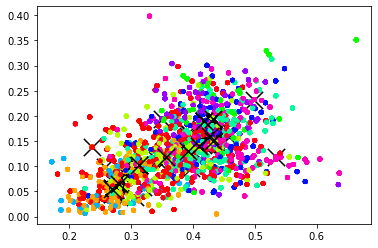

In [51]:
def getAccuracy(labels, prediction):
    return np.sum(labels == prediction)/labels.shape[0]

def runkMeans(X, initial_centroids, max_iters, plot_progress):
    centroids = initial_centroids
    previous_centroids = centroids
    for i in range (max_iters):
        print('K-Means iteration ' + str(i) + '/' + str(max_iters) + '...')
        
        idx = findClosestCentroids(X, centroids)
        
        if plot_progress:
            #Plot datapoints of first two columns 
            plotProgress(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids;
            #display.clear_output(wait=True)
            #display.display(pl.gcf())
        #input("Press enter to continue...")
        prediction = findClosestCentroids(train_data_features.values, centroids)
        accuracy = getAccuracy(train_data_target.values, prediction)
        print("Accuracy on dataset:", accuracy)
        centroids = computeCentroids(X, idx, K)
    return centroids

K = 10;

initial_centroids = initializeCentroids(train_data_features.values, train_data_target.values, K)

final_centroids = runkMeans(train_data_features.values, initial_centroids, 20, True)

#print(train_data_features.head())
#print(train_data_target.head())
prediction = findClosestCentroids(train_data_features.values, final_centroids)
print(getAccuracy(train_data_target.values, prediction))


